In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [2]:
from sklearn.metrics import *

# Preparing data
Using data from [Hugging face](https://huggingface.co/datasets/tweets_hate_speech_detection)

Working reference by Paper
* [Journal 1](https://arxiv.org/pdf/1706.00188v1.pdf)
* [Journal 2](https://dl.acm.org/doi/pdf/10.1145/3447535.3462484)
* [Journal 3](https://arxiv.org/pdf/1803.08977v1.pdf)
* [Journal 4](https://arxiv.org/pdf/2104.10513v1.pdf)


In [3]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 14.6 MB/s eta 0:00:00


In [101]:
from datasets import load_dataset

dataset = load_dataset("tweets_hate_speech_detection")

## load data to DataFrame

In [102]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'tweet'],
        num_rows: 31962
    })
    test: Dataset({
        features: ['label', 'tweet'],
        num_rows: 17197
    })
})

In [103]:
def load_datasets(data,target_data):
  result_dict={}
  data_train=data[target_data]
  texts=[]
  label=[]
  for text,labels in zip(data_train['tweet'],data_train['label']):
    texts.append(text)
    label.append(labels)
  result_dict={
    "tweet":texts,
    "labels":label
  }
  return result_dict

In [104]:
train_df_datasets=load_datasets(data=dataset,target_data='train')

In [105]:
data_train_df=pd.DataFrame(train_df_datasets)

In [106]:
data_train_df

,tweet,labels
0,@user when a father is dysfunctional and is so...,0
1,@user @user thanks for #lyft credit i can't us...,0
2,bihday your majesty,0
3,#model i love u take with u all the time in ...,0
4,factsguide: society now #motivation,0
...,...,...
31957,ate @user isz that youuu?ðððððð...,0
31958,to see nina turner on the airwaves trying to w...,0
31959,listening to sad songs on a monday morning otw...,0
31960,"@user #sikh #temple vandalised in in #calgary,...",1


# EDA

## transform label

Tranform label from https://huggingface.co/datasets/tweets_hate_speech_detection
<br>
* label : 1 - it is a hate speech
* 0 - not a hate speech.


In [134]:
def transform_label(rating):
  if rating==0:
    return "not_hate"
  if rating==1:
    return "hate"

In [108]:
data_train_df['sentiment']=data_train_df['labels'].apply(transform_label)

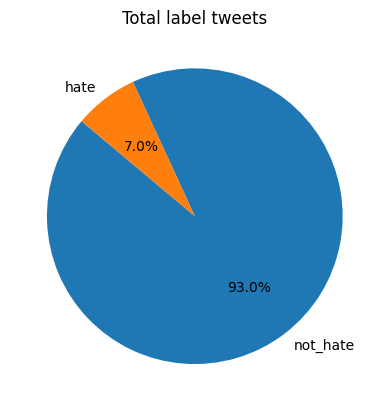

In [109]:
plt.pie(x=data_train_df['sentiment'].value_counts(),labels=data_train_df['sentiment'].unique(),autopct='%1.1f%%',startangle=140)
plt.title("Total label tweets")
plt.show()

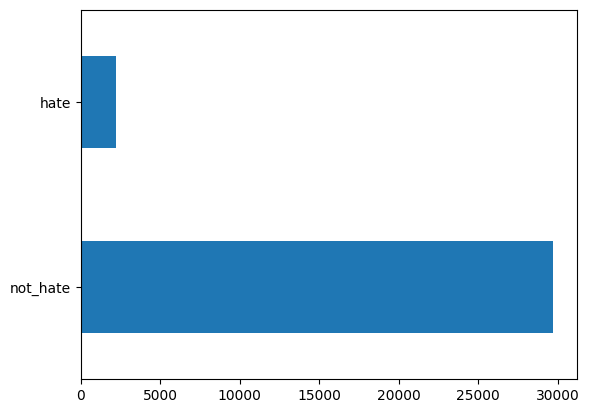

In [110]:
data_train_df.sentiment.value_counts().plot.barh();

`Looks like`
* 0 label is not hate
* 1 labels is hate speech
* not hate aka 0 is most common label than label 1 (hate speech)



## Wordlcoud

In [113]:
import cv2
from wordcloud import WordCloud

In [114]:
!wget https://raw.githubusercontent.com/ackermanjayjay/transer-news-sentiment/main/cloud.jpg

--2023-09-30 00:26:52--  https://raw.githubusercontent.com/ackermanjayjay/transer-news-sentiment/main/cloud.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34396 (34K) [image/jpeg]
Saving to: ‘cloud.jpg.3’

cloud.jpg.3         100%[===================>]  33.59K  --.-KB/s    in 0.01s   

2023-09-30 00:26:53 (3.19 MB/s) - ‘cloud.jpg.3’ saved [34396/34396]



In [115]:
originalImage = cv2.imread('cloud.jpg')
grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
(thresh, cloud_mask) = cv2.threshold(grayImage, 100, 255, cv2.THRESH_BINARY)

def word_cloud(data,clean_columns_data,columnsTargetLabel,label):

  data_target = data[data[columnsTargetLabel] == label]
  string_label = []

  for t in data_target[clean_columns_data]:
    string_label .append(t)

  string_label = pd.Series(string_label).str.cat(sep=' ')

  wordcloud = WordCloud(width=1600, height=800, margin=10,
                        background_color='white', colormap='Dark2',
                        max_font_size=200, min_font_size=25,
                        mask=cloud_mask, contour_width=10, contour_color='firebrick',
                        max_words=100).generate(string_label)
  plt.figure(figsize=(10,8))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.title(label)
  plt.show()

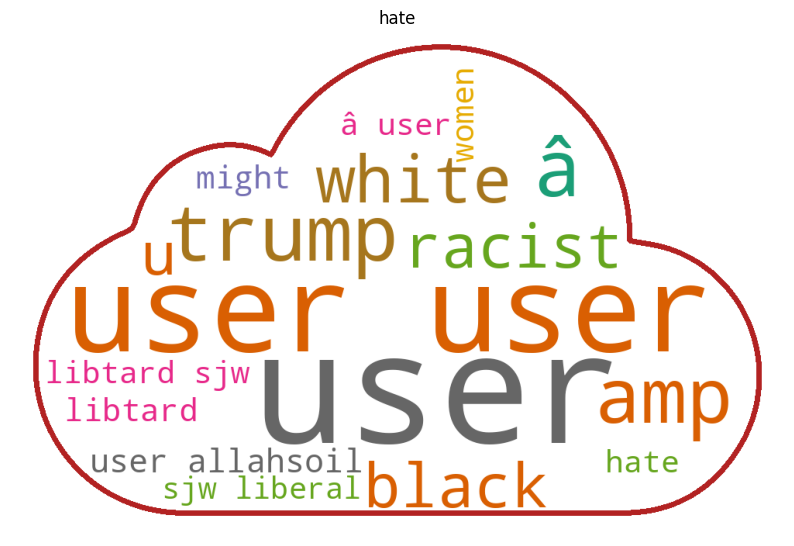

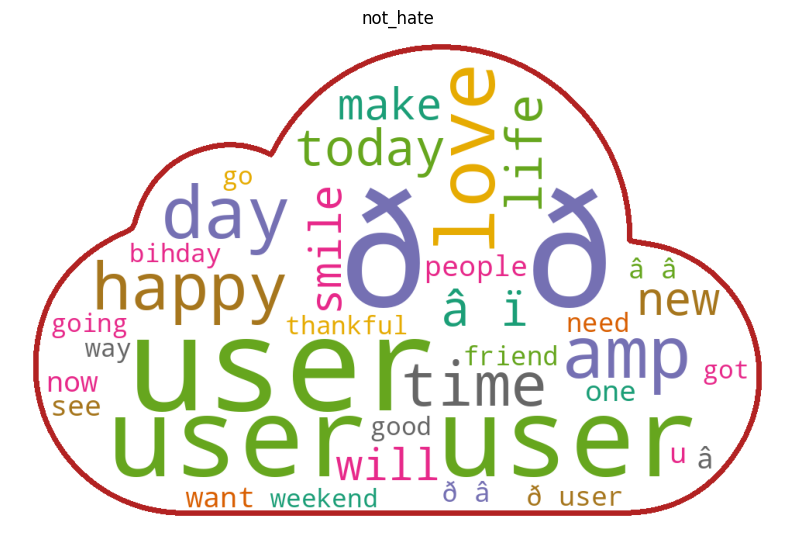

In [116]:
import numpy as np
label_string=[]
for label in data_train_df["sentiment"]:
    label_string.append(label)
for label in np.unique(label_string):
            word_cloud(data=data_train_df,
            clean_columns_data="tweet",
            columnsTargetLabel="sentiment",
            label=(label))

## Vector words

In [117]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [118]:
bag_of_words=CountVectorizer()
corpus=data_train_df['tweet']
bag_of_words_tweets=bag_of_words.fit_transform(corpus).toarray()

In [119]:
data_bag_of_words=pd.DataFrame({
    'features':bag_of_words.get_feature_names_out(),
    'scores_freq':bag_of_words_tweets.sum(axis=0)
})
top_ten_most_words_bag_of_words=data_bag_of_words.sort_values(by='scores_freq',ascending=False).head(10)

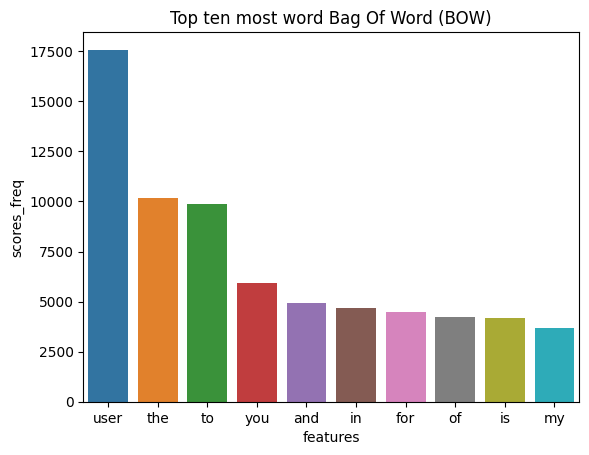

In [120]:
sns.barplot(data=top_ten_most_words_bag_of_words,x='features',y='scores_freq')
plt.title('Top ten most word Bag Of Word (BOW)')
plt.show()

the ten words that appear the most are stopwords
* the
* to
* you
* and
* in
* for
* of
* is
* my

And must doing preprocessing
* Casefolding
* Remove stopwords
* Remove punctuation and number
* Stemming

## Preprocessing

In [121]:
def caseFolding(text):
  text=text.lower()
  return text


import re
def punc_removal(text):
  text=re.sub(r"[^a-zA-Z]"," ",text)
  return text

# import StemmerFactory class

# create stemmer
import nltk
from nltk import *
stemmer = PorterStemmer()
def stemsWords(text):
  text=stemmer.stem(text)
  return text

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('stopwords')
stp=stopwords.words('english')

def flatten(l):
    """
    Same as
    flat_list = []
    for sublist in l:
    for item in sublist:
        flat_list.append(item)

    Example =[[1,2,3,4,5]] - > [1,2,3,4,5]
    """
    return " ".join([item for sublist in l for item in sublist])

def remove_stop_words(text):
  stopWords_add=['us','like']
  stopWords_combine=stopWords_add+stp
  clean_words = []
  text=text.split()
  perulangan_text=[word for word in text if word not in stopWords_combine]
  clean_words.append(perulangan_text)
  return flatten(clean_words)

def preprocessing_text(text):
  text=caseFolding(text)
  text=punc_removal(text)
  text=remove_stop_words(text)
  text=stemsWords(text)
  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [122]:
data_train_df['clean_text_tweet']=data_train_df['tweet'].apply(preprocessing_text)

In [123]:
bag_of_words_clean_tweets=CountVectorizer()
corpus_tweets_clean=data_train_df['clean_text_tweet']
bag_of_words_tweetsClean=bag_of_words_clean_tweets.fit_transform(corpus_tweets_clean).toarray()

In [124]:
data_bag_of_words_tweetsClean=pd.DataFrame({
    'features':bag_of_words_clean_tweets.get_feature_names_out(),
    'scores_freq':bag_of_words_tweetsClean.sum(axis=0)
})
top_ten_most_words_bag_of_words_cleanTweets=data_bag_of_words_tweetsClean.sort_values(by='scores_freq',ascending=False).head(10)

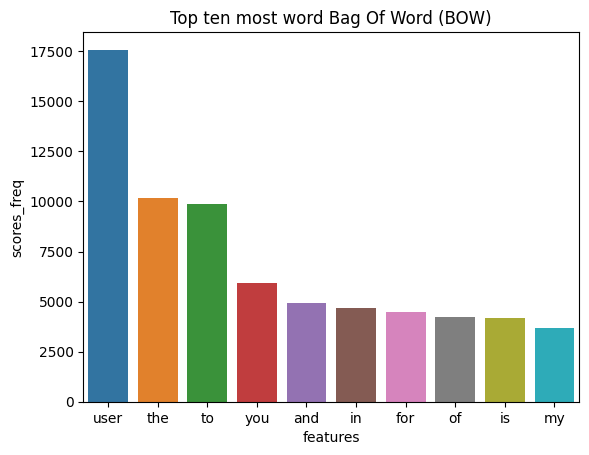

In [125]:
sns.barplot(data=top_ten_most_words_bag_of_words,x='features',y='scores_freq')
plt.title('Top ten most word Bag Of Word (BOW)')
plt.show()

most word is `user`

## Wordcloud after preprocessing

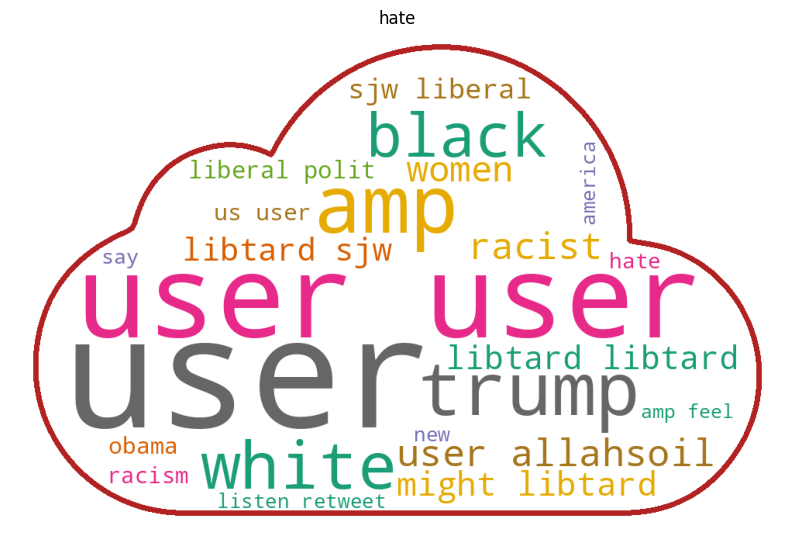

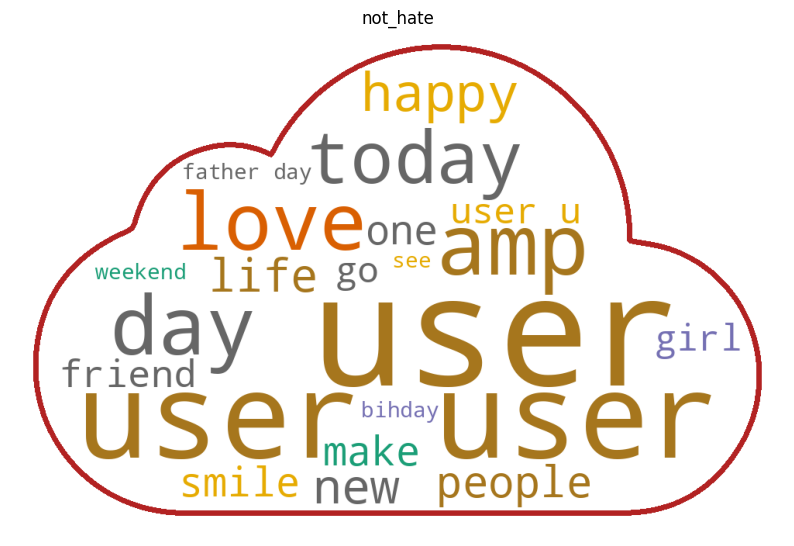

In [126]:
import numpy as np
label_string=[]
for label in data_train_df["sentiment"]:
    label_string.append(label)
for label in np.unique(label_string):
            word_cloud(data=data_train_df,
            clean_columns_data="clean_text_tweet",
            columnsTargetLabel="sentiment",
            label=(label))

## Total lines

In [87]:
data_train_df['total_lines_before_preprocess']=data_train_df['tweet'].apply(lambda n : len(n.split()))

In [88]:
data_train_df

,tweet,labels,clean_text_tweet,sentiment,total_lines_before_preprocess,total_lines_after_preprocess
0,@user when a father is dysfunctional and is so...,0,user father dysfunctional selfish drags kids d...,not_hate,18,8
1,@user @user thanks for #lyft credit i can't us...,0,user user thanks lyft credit use cause offer w...,not_hate,19,13
2,bihday your majesty,0,bihday majesti,not_hate,3,2
3,#model i love u take with u all the time in ...,0,model love u take u time ur,not_hate,14,7
4,factsguide: society now #motivation,0,factsguide society motiv,not_hate,4,3
...,...,...,...,...,...,...
31957,ate @user isz that youuu?ðððððð...,0,ate user isz youuu,not_hate,5,4
31958,to see nina turner on the airwaves trying to w...,0,see nina turner airwaves trying wrap mantle ge...,not_hate,23,13
31959,listening to sad songs on a monday morning otw...,0,listening sad songs monday morning otw work sad,not_hate,13,8
31960,"@user #sikh #temple vandalised in in #calgary,...",1,user sikh temple vandalised calgary wso condem...,hate,10,8


In [89]:
data_train_df['tweet'][0]

'@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

Check distribution length tweets

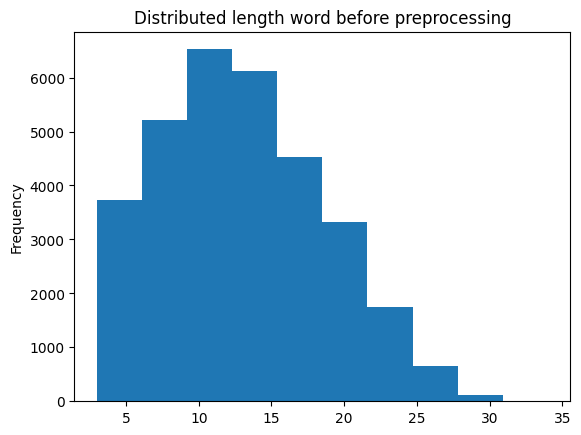

In [90]:
data_train_df['total_lines_before_preprocess'].plot.hist();
plt.title("Distributed length word before preprocessing")
plt.show()

Okay, looks like most of the tweets are around 5 to 25 sentences in length.

It's good to check these things out to make sure when we do train a model or test it on unseen samples, our results aren't outlandish.

## total lines after preprocessing

In [91]:
data_train_df['total_lines_after_preprocess']=data_train_df['clean_text_tweet'].apply(lambda n : len(n.split()))

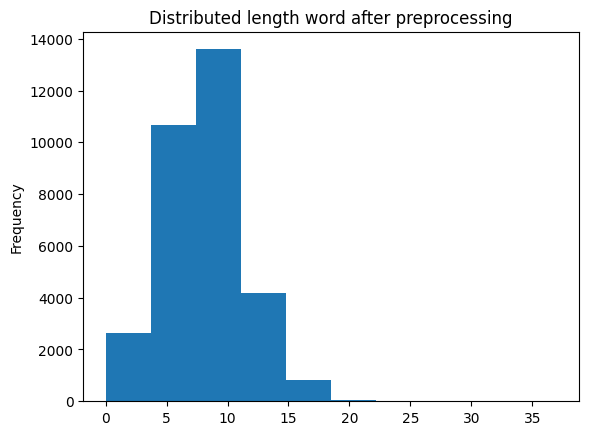

In [92]:
data_train_df['total_lines_after_preprocess'].plot.hist();
plt.title("Distributed length word after preprocessing")
plt.show()

there is a change there may be a word that is deleted, namely the conjunction tweets are around 5 to 10 sentences in length.


# Baseline model

# TFIDF

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer

## after preprocessing

In [135]:
X_korpus=data_train_df['clean_text_tweet']
y_label=data_train_df['labels']

In [136]:
from sklearn.model_selection import train_test_split
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_korpus, y_label, test_size=0.1, random_state=42)

In [137]:
print(f'Total data train: {len(X_train_tfidf)}')
print(f'Total data test: {len(X_test_tfidf)}')

Total data train: 28765
Total data test: 3197


In [138]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

### Naives bayes

In [139]:
model_naivesBayes_preprocess_tfidf=Pipeline([
    ('count vector',TfidfVectorizer()),
    ('Naives bayes',MultinomialNB())
])

In [140]:
model_naivesBayes_preprocess_tfidf.fit(X_train_tfidf,y_train_tfidf)

Pipeline(steps=[('count vector', TfidfVectorizer()),
                ('Naives bayes', MultinomialNB())])

#### Evaluation

In [141]:
predict_naives_bayes_preprocess_tfidf=model_naivesBayes_preprocess_tfidf.predict(X_test_tfidf)

In [147]:
predict_naives_bayes_preprocess_tfidf

array([0, 0, 0, ..., 0, 0, 0])

In [146]:
y_test_tfidf.unique()

array([0, 1])

In [145]:
wrong_predict_NB_=(y_test_tfidf!=predict_naives_bayes_preprocess_tfidf).sum()
correct_predict_NB_=(y_test_tfidf==predict_naives_bayes_preprocess_tfidf).sum()
predict_hate_label=(predict_naives_bayes_preprocess_tfidf==0).sum()
predict_not_hate_label=(predict_naives_bayes_preprocess_tfidf==1).sum()
labels_true_hate_speech=(y_test_tfidf==0).sum()
label_true_not_hate=(y_test_tfidf!=0).sum()
print(f'Support label 0 : {labels_true_hate_speech}')
print(f'Support label 1 : {label_true_not_hate}')
print(f'Total predict hate label : {predict_hate_label}')
print(f'Total predict not hate label : {predict_not_hate_label}')
print(f'Wrong prediction: {wrong_predict_NB_}')
print(f'Correct prediction: {correct_predict_NB_}\n')
print(classification_report(y_true=y_test_tfidf,y_pred=predict_naives_bayes_preprocess_tfidf))

Support label 0 : 2984
Support label 1 : 213
Total predict hate label : 3168
Total predict not hate label : 29
Wrong prediction: 184
Correct prediction: 3013

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2984
           1       1.00      0.14      0.24       213

    accuracy                           0.94      3197
   macro avg       0.97      0.57      0.60      3197
weighted avg       0.95      0.94      0.92      3197



In [164]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [167]:
result_nb_tfidf_preprocess=calculate_results(y_true=y_test_tfidf,y_pred=predict_naives_bayes_preprocess_tfidf)
result_nb_tfidf_preprocess

{'accuracy': 94.24460431654677,
 'precision': 0.9457888234866653,
 'recall': 0.9424460431654677,
 'f1': 0.9214267163792637}

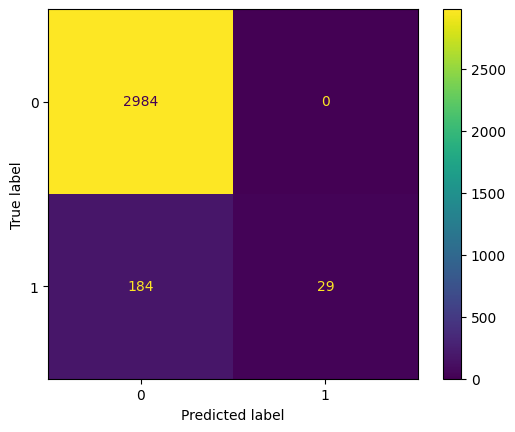

In [171]:
class_nb_tfidf_preprocess=model_naivesBayes_preprocess_tfidf['Naives bayes'].classes_
cm_nb_tfidf_preprocess = confusion_matrix(y_test_tfidf, predict_naives_bayes_preprocess_tfidf, labels=class_nb_tfidf_preprocess)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nb_tfidf_preprocess,
                               display_labels=class_nb_tfidf_preprocess)
disp.plot()
plt.show()

### KNN

In [50]:
model_knn_tfidf=Pipeline([
    ('count vector',TfidfVectorizer()),
    ('KNN',KNeighborsClassifier(metric='cosine'))
])

In [52]:
model_knn_tfidf.fit(X_train_tfidf,y_train_tfidf)

Pipeline(steps=[('count vector', TfidfVectorizer()),
                ('KNN', KNeighborsClassifier(metric='cosine'))])

#### Evaluation

In [53]:
classes_=model_knn_tfidf['KNN'].classes_
classes_

array([0, 1])

In [151]:
predict_knn_tfidf=model_knn_tfidf.predict(X_test_tfidf)

In [152]:
predict_knn_tfidf

array([0, 0, 0, ..., 0, 0, 0])

In [148]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [160]:
result_knn_tfidf_preprocess=calculate_results(y_test_tfidf,predict_knn_tfidf)
result_knn_tfidf_preprocess

{'accuracy': 95.0578667500782,
 'precision': 0.9472683962387102,
 'recall': 0.950578667500782,
 'f1': 0.9390489244109381}

In [154]:
tn_knn, fp_knn, fn_knn, tp_knn = confusion_matrix(y_test_tfidf,predict_knn_tfidf).ravel()

In [155]:
wrong_predict_knn_=(y_test_tfidf!=predict_knn_tfidf).sum()
correct_predict_knn_=(y_test_tfidf==predict_knn_tfidf).sum()
predict_hate_label=(predict_knn_tfidf==0).sum()
predict_not_hate_label=(predict_knn_tfidf==1).sum()
labels_true_hate_speech=(y_test_tfidf==0).sum()
label_true_not_hate=(y_test_tfidf!=0).sum()
print(f'Support label 0 : {labels_true_hate_speech}')
print(f'Support label 1 : {label_true_not_hate}')
print(f'Total predict hate label : {predict_hate_label}')
print(f'Total predict not hate label : {predict_not_hate_label}')
print(f'Wrong prediction: {wrong_predict_knn_}')
print(f'Correct prediction: {correct_predict_knn_}\n')
print(classification_report(y_true=y_test_tfidf,y_pred=predict_knn_tfidf))

Support label 0 : 2984
Support label 1 : 213
Total predict hate label : 3124
Total predict not hate label : 73
Wrong prediction: 158
Correct prediction: 3039

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2984
           1       0.88      0.30      0.45       213

    accuracy                           0.95      3197
   macro avg       0.91      0.65      0.71      3197
weighted avg       0.95      0.95      0.94      3197



Describtion about `Support` metrics: <br>
The support is the number of occurrences of each class in y_true.
[Source](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#:~:text=The%20support%20is%20the%20number,weighted'%20or%20'samples'%20.)



In [156]:
pd.DataFrame(classification_report(y_true=y_test_tfidf,y_pred=predict_knn_tfidf,output_dict='dict'))

,0,1,accuracy,macro avg,weighted avg
precision,0.952305,0.876712,0.950579,0.914509,0.947268
recall,0.996984,0.300469,0.950579,0.648727,0.950579
f1-score,0.974132,0.447552,0.950579,0.710842,0.939049
support,2984.000000,213.000000,0.950579,3197.000000,3197.000000


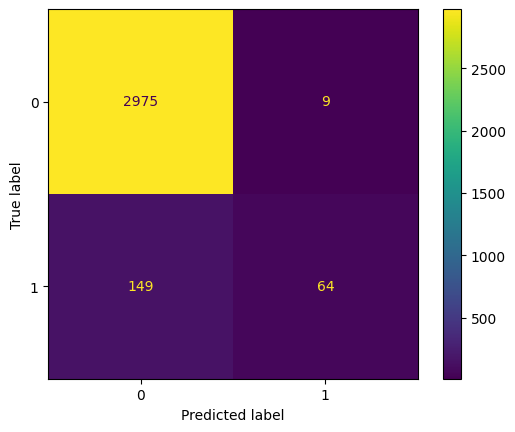

In [157]:
cm_knn = confusion_matrix(y_test_tfidf, predict_knn_tfidf, labels=classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn,
                               display_labels=classes_)
disp.plot()
plt.show()

In [158]:
print(f'true positive: {tp_knn}')
print(f'true negatif: {tn_knn}')
print(f'false positive: {fp_knn}')
print(f'false negative: {fn_knn}')

true positive: 64
true negatif: 2975
false positive: 9
false negative: 149


# Bag of Words

## after preprocessing

In [172]:
X_korpus=data_train_df['clean_text_tweet']
y_label=data_train_df['labels']

In [321]:
from sklearn.model_selection import train_test_split
X_train_after_preprocess, X_test_after_preprocess, y_train_after_preprocess, y_test_after_preprocess = train_test_split(X_korpus, y_label, test_size=0.1, random_state=42)

In [322]:
print(f'Total data train: {len(X_train_after_preprocess)}')
print(f'Total data test: {len(X_test_after_preprocess)}')

Total data train: 28765
Total data test: 3197


In [175]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

### Naives bayes

In [323]:
model_naivesBayes=Pipeline([
    ('count vector',CountVectorizer()),
    ('Niaves bayes',MultinomialNB())
])

In [324]:
model_naivesBayes.fit(X_train_after_preprocess,y_train_after_preprocess)

Pipeline(steps=[('count vector', CountVectorizer()),
                ('Niaves bayes', MultinomialNB())])

#### Evaluation

In [325]:
predict_naives_bayes=model_naivesBayes.predict(X_test_after_preprocess)

In [326]:
wrong_predict_NB_=(y_test_after_preprocess!=predict_naives_bayes).sum()
correct_predict_NB_=(y_test_after_preprocess==predict_naives_bayes).sum()
predict_hate_label=(predict_naives_bayes==0).sum()
predict_not_hate_label=(predict_naives_bayes==1).sum()
labels_true_hate_speech=(y_test_after_preprocess==0).sum()
label_true_not_hate=(y_test_after_preprocess!=0).sum()
print(f'Support label 0 : {labels_true_hate_speech}')
print(f'Support label 1 : {label_true_not_hate}')
print(f'Total predict hate label : {predict_hate_label}')
print(f'Total predict not hate label : {predict_not_hate_label}')
print(f'Wrong prediction: {wrong_predict_NB_}')
print(f'Correct prediction: {correct_predict_NB_}\n')
print(classification_report(y_true=y_test_after_preprocess,y_pred=predict_naives_bayes))

Support label 0 : 2984
Support label 1 : 213
Total predict hate label : 3098
Total predict not hate label : 99
Wrong prediction: 140
Correct prediction: 3057

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2984
           1       0.87      0.40      0.55       213

    accuracy                           0.96      3197
   macro avg       0.91      0.70      0.76      3197
weighted avg       0.95      0.96      0.95      3197



### KNN

In [180]:
model_knn=Pipeline([
    ('count vector',CountVectorizer()),
    ('KNN',KNeighborsClassifier(metric='cosine'))
])

In [327]:
model_knn.fit(X_train_after_preprocess,y_train_after_preprocess)

Pipeline(steps=[('count vector', CountVectorizer()),
                ('KNN', KNeighborsClassifier(metric='cosine'))])

#### Evaluation

In [328]:
classes_=model_knn['KNN'].classes_
classes_

array([0, 1])

In [332]:
predict_knn_after_preprocess=model_knn.predict(X_test_after_preprocess)

In [333]:
predict_knn_after_preprocess

array([0, 0, 0, ..., 0, 1, 0])

In [184]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [316]:
result_knn_after_preprocessing_bagOfWord=calculate_results(y_test_after_preprocess,predict_knn)
result_knn_after_preprocessing_bagOfWord

{'accuracy': 94.65123553331249,
 'precision': 0.9385045421514765,
 'recall': 0.9465123553331248,
 'f1': 0.9352107137904165}

In [186]:
tn_knn, fp_knn, fn_knn, tp_knn = confusion_matrix(y_test_after_preprocess,predict_knn_after_preprocess).ravel()

In [334]:
wrong_predict_knn_=(y_test_after_preprocess!=predict_knn_after_preprocess).sum()
correct_predict_knn_=(y_test_after_preprocess==predict_knn_after_preprocess).sum()
predict_hate_label=(predict_knn_after_preprocess==0).sum()
predict_not_hate_label=(predict_knn_after_preprocess==1).sum()
labels_true_hate_speech=(y_test_after_preprocess==0).sum()
label_true_not_hate=(y_test_after_preprocess!=0).sum()
print(f'Support label 0 : {labels_true_hate_speech}')
print(f'Support label 1 : {label_true_not_hate}')
print(f'Total predict hate label : {predict_hate_label}')
print(f'Total predict not hate label : {predict_not_hate_label}')
print(f'Wrong prediction: {wrong_predict_knn_}')
print(f'Correct prediction: {correct_predict_knn_}\n')
print(classification_report(y_true=y_test_after_preprocess,y_pred=predict_knn_after_preprocess))

Support label 0 : 2984
Support label 1 : 213
Total predict hate label : 3115
Total predict not hate label : 82
Wrong prediction: 171
Correct prediction: 3026

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2984
           1       0.76      0.29      0.42       213

    accuracy                           0.95      3197
   macro avg       0.85      0.64      0.70      3197
weighted avg       0.94      0.95      0.94      3197



Describtion about `Support` metrics: <br>
The support is the number of occurrences of each class in y_true.
[Source](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#:~:text=The%20support%20is%20the%20number,weighted'%20or%20'samples'%20.)



In [335]:
pd.DataFrame(classification_report(y_true=y_test_after_preprocess,y_pred=predict_knn_after_preprocess,output_dict='dict'))

,0,1,accuracy,macro avg,weighted avg
precision,0.951525,0.756098,0.946512,0.853811,0.938505
recall,0.993298,0.291080,0.946512,0.642189,0.946512
f1-score,0.971963,0.420339,0.946512,0.696151,0.935211
support,2984.000000,213.000000,0.946512,3197.000000,3197.000000


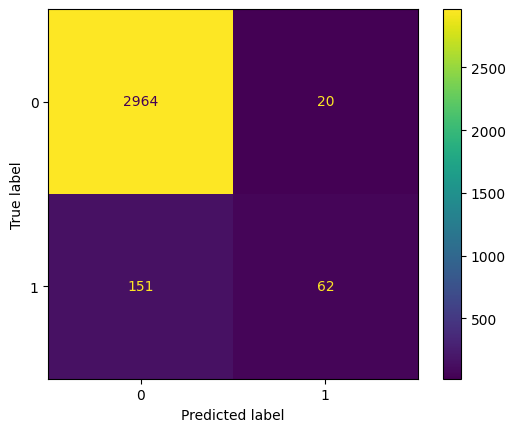

In [336]:
cm_knn = confusion_matrix(y_test_after_preprocess, predict_knn_after_preprocess, labels=classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn,
                               display_labels=classes_)
disp.plot()
plt.show()

In [190]:
print(f'true positive: {tp_knn}')
print(f'true negatif: {tn_knn}')
print(f'false positive: {fp_knn}')
print(f'false negative: {fn_knn}')

true positive: 64
true negatif: 2975
false positive: 9
false negative: 149


In [191]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

## before preprocessing

In [192]:
X_korpus=data_train_df['tweet']
y_label=data_train_df['labels']

In [337]:
from sklearn.model_selection import train_test_split
X_train_before_preprocessing, X_test_before_preprocessing, y_train_before_preprocessing, y_test_before_preprocessing = train_test_split(X_korpus, y_label, test_size=0.1, random_state=42)

In [338]:
print(f'Total data train: {len(X_train_before_preprocessing)}')
print(f'Total data test: {len(X_test_before_preprocessing)}')

Total data train: 28765
Total data test: 3197


### Naives bayes

In [339]:
model_naivesBayes_before_preprocessing=Pipeline([
    ('count vector',CountVectorizer()),
    ('Niaves bayes',MultinomialNB())
])

In [341]:
model_naivesBayes_before_preprocessing.fit(X_train_before_preprocessing,y_train_before_preprocessing)

Pipeline(steps=[('count vector', CountVectorizer()),
                ('Niaves bayes', MultinomialNB())])

#### Evaluation

In [350]:
predict_naives_bayes_before_preprocessing=model_naivesBayes_before_preprocessing.predict(X_test_before_preprocessing)

In [351]:
wrong_predict_NB_=(y_test_before_preprocessing!=predict_naives_bayes_before_preprocessing).sum()



correct_predict_NB_=(y_test_before_preprocessing==predict_naives_bayes_before_preprocessing).sum()
predict_hate_label=(predict_naives_bayes_before_preprocessing==0).sum()
predict_not_hate_label=(predict_naives_bayes_before_preprocessing==1).sum()
labels_true_hate_speech=(y_test_before_preprocessing==0).sum()
label_true_not_hate=(y_test_before_preprocessing!=0).sum()
print(f'Support label 0 : {labels_true_hate_speech}')
print(f'Support label 1 : {label_true_not_hate}')
print(f'Total predict hate label : {predict_hate_label}')
print(f'Total predict not hate label : {predict_not_hate_label}')
print(f'Wrong prediction: {wrong_predict_NB_}')
print(f'Correct prediction: {correct_predict_NB_}\n')
print(classification_report(y_true=y_test_before_preprocessing,y_pred=predict_naives_bayes_before_preprocessing))

Support label 0 : 2984
Support label 1 : 213
Total predict hate label : 3098
Total predict not hate label : 99
Wrong prediction: 140
Correct prediction: 3057

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2984
           1       0.87      0.40      0.55       213

    accuracy                           0.96      3197
   macro avg       0.91      0.70      0.76      3197
weighted avg       0.95      0.96      0.95      3197



### KNN

In [353]:
model_knn_before_preprocessing=Pipeline([
    ('count vector',CountVectorizer()),
    ('KNN',KNeighborsClassifier(metric='cosine'))
])

In [354]:
model_knn_before_preprocessing.fit(X_train_before_preprocessing,y_train_before_preprocessing)

Pipeline(steps=[('count vector', CountVectorizer()),
                ('KNN', KNeighborsClassifier(metric='cosine'))])

#### Evaluation

In [202]:
classes_=model_knn['KNN'].classes_
classes_

array([0, 1])

In [355]:
predict_knn_before_preprocessing=model_knn_before_preprocessing.predict(X_test_before_preprocessing)

In [356]:
predict_knn

array([0, 0, 0, ..., 0, 1, 0])

In [357]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [358]:
result_knn_before_preprocessing=calculate_results(y_test_before_preprocessing,predict_knn_before_preprocessing)
result_knn_before_preprocessing

{'accuracy': 94.65123553331249,
 'precision': 0.9385045421514765,
 'recall': 0.9465123553331248,
 'f1': 0.9352107137904165}

In [315]:
tn_knn, fp_knn, fn_knn, tp_knn = confusion_matrix(y_test,predict_knn).ravel()

In [359]:
wrong_predict_knn_=(y_test_before_preprocessing!=predict_knn_before_preprocessing).sum()
correct_predict_knn_=(y_test_before_preprocessing==predict_knn).sum()
predict_hate_label=(predict_knn_before_preprocessing==0).sum()
predict_not_hate_label=(predict_knn_before_preprocessing==1).sum()
labels_true_hate_speech=(y_test_before_preprocessing==0).sum()
label_true_not_hate=(y_test_before_preprocessing!=0).sum()
print(f'Support label 0 : {labels_true_hate_speech}')
print(f'Support label 1 : {label_true_not_hate}')
print(f'Total predict hate label : {predict_hate_label}')
print(f'Total predict not hate label : {predict_not_hate_label}')
print(f'Wrong prediction: {wrong_predict_knn_}')
print(f'Correct prediction: {correct_predict_knn_}\n')
print(classification_report(y_true=y_test_before_preprocessing,y_pred=predict_knn_before_preprocessing))

Support label 0 : 2984
Support label 1 : 213
Total predict hate label : 3115
Total predict not hate label : 82
Wrong prediction: 171
Correct prediction: 3026

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2984
           1       0.76      0.29      0.42       213

    accuracy                           0.95      3197
   macro avg       0.85      0.64      0.70      3197
weighted avg       0.94      0.95      0.94      3197



Describtion about `Support` metrics: <br>
The support is the number of occurrences of each class in y_true.
[Source](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#:~:text=The%20support%20is%20the%20number,weighted'%20or%20'samples'%20.)



In [360]:
pd.DataFrame(classification_report(y_true=y_test_before_preprocessing,y_pred=predict_knn_before_preprocessing,output_dict='dict'))

,0,1,accuracy,macro avg,weighted avg
precision,0.951525,0.756098,0.946512,0.853811,0.938505
recall,0.993298,0.291080,0.946512,0.642189,0.946512
f1-score,0.971963,0.420339,0.946512,0.696151,0.935211
support,2984.000000,213.000000,0.946512,3197.000000,3197.000000


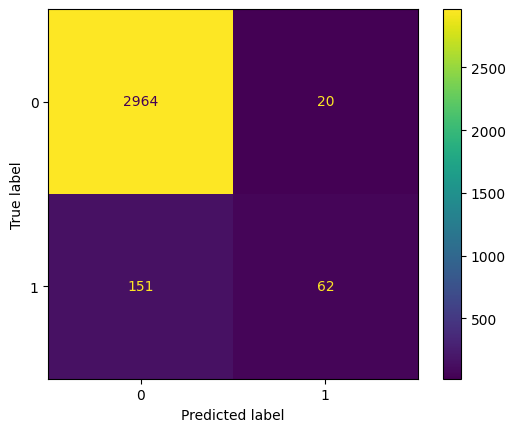

In [361]:
cm_knn = confusion_matrix(y_test_before_preprocessing, predict_knn_before_preprocessing, labels=classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn,
                               display_labels=classes_)
disp.plot()
plt.show()

In [213]:
print(f'true positive: {tp_knn}')
print(f'true negatif: {tn_knn}')
print(f'false positive: {fp_knn}')
print(f'false negative: {fn_knn}')

true positive: 62
true negatif: 2964
false positive: 20
false negative: 151


# Transfer learning Encoder

In [215]:
import tensorflow_hub as hub

In [216]:
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [219]:
train_sentences=data_train_df['clean_text_tweet'].tolist()

In [276]:
import random
random_training_sentence = random.choice(train_sentences)
vectorizer = TfidfVectorizer()
# tfidf_vec=vectorizer.fit_transform([random_training_sentence])
print(f"Random training sentence:\n{random_training_sentence}\n")
use_tfidf =vectorizer.fit_transform([random_training_sentence])
print(f"Sentence after embedding:\n{use_tfidf.toarray()} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_tfidf.toarray())}")

Random training sentence:
afternoon snack fun

Sentence after embedding:
[[0.57735027 0.57735027 0.57735027]] (truncated output)...

Length of sentence embedding:
1


In [279]:
import random
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
could resist good food monks road lincoln

Sentence after embedding:
[ 0.05321374 -0.01955708  0.04115213 -0.03743489  0.04253589  0.06647617
 -0.02588164 -0.05183988 -0.07880874 -0.00308756  0.02823347  0.0506893
 -0.03215081  0.03440557 -0.08219273 -0.0473306  -0.02034082  0.00538011
  0.01791489 -0.05209817  0.04542892 -0.06471159  0.07988509 -0.04314621
  0.00034405 -0.0520411   0.04114143  0.03605902 -0.07516382 -0.06846565] (truncated output)...

Length of sentence embedding:
512


In [280]:
X_embed=tf_hub_embedding_layer(train_sentences)
X_embed=[value for value in X_embed]

In [296]:
X_train_embed, X_test_embed, y_train_embed, y_test_embed = train_test_split(X_embed, y_label, test_size=0.2, random_state=42)

In [293]:
from imblearn.pipeline import Pipeline as PipelineSmote
from imblearn.over_sampling import SMOTE
model_knn_smote=PipelineSmote([
    ('over sampling',SMOTE(random_state=0)), #  handling imbalance labels SMOTE over-sampling
    ('KNN',KNeighborsClassifier(metric='cosine'))
])

In [294]:
%%time
model_knn_smote.fit(X_train_embed,y_train_embed)

CPU times: user 5.83 s, sys: 1.17 s, total: 7 s
Wall time: 13.5 s


Pipeline(steps=[('over sampling', SMOTE(random_state=0)),
                ('KNN', KNeighborsClassifier(metric='cosine'))])

In [297]:
%%time
model_predict_knn_embed_smote=model_knn_smote.predict(X_test_embed)
result_knn_smote_embed=calculate_results(y_test_embed,model_predict_knn_embed_smote)

CPU times: user 25.2 s, sys: 3.28 s, total: 28.4 s
Wall time: 21.8 s


In [301]:
wrong_predict_NB_=(y_test_embed!=model_predict_knn_embed_smote).sum()
correct_predict_NB_=(y_test_embed==model_predict_knn_embed_smote).sum()
predict_hate_label=(model_predict_knn_embed_smote==0).sum()
predict_not_hate_label=(model_predict_knn_embed_smote==1).sum()
labels_true_hate_speech=(y_test_embed==0).sum()
label_true_not_hate=(y_test_embed!=0).sum()
print(f'Support label 0 : {labels_true_hate_speech}')
print(f'Support label 1 : {label_true_not_hate}')
print(f'Total predict hate label : {predict_hate_label}')
print(f'Total predict not hate label : {predict_not_hate_label}')
print(f'Wrong prediction: {wrong_predict_NB_}')
print(f'Correct prediction: {correct_predict_NB_}\n')
print(classification_report(y_true=y_test_embed,y_pred=model_predict_knn_embed_smote))

Support label 0 : 5937
Support label 1 : 456
Total predict hate label : 5199
Total predict not hate label : 1194
Wrong prediction: 840
Correct prediction: 5553

              precision    recall  f1-score   support

           0       0.99      0.87      0.92      5937
           1       0.34      0.89      0.49       456

    accuracy                           0.87      6393
   macro avg       0.66      0.88      0.71      6393
weighted avg       0.94      0.87      0.89      6393



In [298]:
result_knn_smote_embed

{'accuracy': 86.86062881276396,
 'precision': 0.9437562799476761,
 'recall': 0.8686062881276396,
 'f1': 0.8936368674691705}

# Summary

In [362]:
result_knn=pd.DataFrame([result_knn_smote_embed,result_knn_before_preprocessing,
                         result_knn_after_preprocessing_bagOfWord,
                         result_knn_tfidf_preprocess],index=['KNN embed Smote','KNN before preprocessing bag of words',
                                                            'result_knn_after_preprocessing_bagOfWord',
                                                             ' result_knn_tfidf_preprocess'])

In [363]:
result_knn

,accuracy,precision,recall,f1
KNN embed Smote,86.860629,0.943756,0.868606,0.893637
KNN before preprocessing bag of words,94.651236,0.938505,0.946512,0.935211
result_knn_after_preprocessing_bagOfWord,94.651236,0.938505,0.946512,0.935211
result_knn_tfidf_preprocess,95.057867,0.947268,0.950579,0.939049
